# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/github/jackhuang-intel/APS360/blob/main/Lab5/Lab5%20Spam%20Detection.ipynb

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
!pip install -U torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [3]:
found_ham = False
found_spam = False
for line in open('SMSSpamCollection'):
    if found_ham and found_spam:
        break
    if not found_ham and line.split('ham'):
        found_ham = True
        print(line)

    if not found_spam and line.startswith('spam'):
        found_spam = True
        print(line)

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



**Answer**

label value for spam is "spam", and label value for non-spam is "ham"

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [4]:
num_spam = 0
num_ham = 0
for line in open('SMSSpamCollection'):
    if line.startswith('ham'):
        num_ham += 1
    elif line.startswith('spam'):
        num_spam += 1

print("Number of non-spam: ", num_ham)
print('Number of spam: ', num_spam)

Number of non-spam:  4827
Number of spam:  747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Answer**

Advantage:
- The model captures fine-grained representation of the sms. The subtle nuances, such as variations in spelling and punctuation may convey important information.
- The model can handle mis-spelt words and slang that may not be pre-defined, as the characters are inherently known

Disadvantage:
- Increased sequence length, or more tokens, which increases the computatinal complexity and memory
- loss of semantic meaning

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [123]:
import torchtext

text_field = torchtext.data.Field(
    sequential=True,
    tokenize=lambda x: x,
    include_lengths=True,
    batch_first=True,
    use_vocab=True
)
label_field = torchtext.data.Field(
    sequential=False,
    is_target=True,
    batch_first=True,
    preprocessing=lambda x: int(x == 'spam') # convert text to 0 and 1
)

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", "tsv", fields)
train, valid, test = dataset.split([0.6, 0.2, 0.2], True)

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [124]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

print("New length of the training: ", len(train.examples))

New length of the training:  6031


**Answer**

A balanced training set is helpful because it helps prevent the model from becoming biased towards one class.  If there are way more non-spam data than spam data, the model may just default most of its guesses towards non-spam and be correct more often than not.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [125]:
text_field.build_vocab(train)
label_field.build_vocab(train)
#text_field.vocab.stoi
#text_field.vocab.itos

**Answer**

Stoi: A collections.defaultdict instance mapping token strings to numerical identifiers.

itos: A list of token strings indexed by their numerical identifiers.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**Answer**

`<unk>` are unknown unknown characters, which doesn't exist in the vocab set.

`<pad>` are padding tokens. It is used to pad data to the same length within a batch of data.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [126]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [129]:
count = 0
for batch in train_iter:
    if count >= 10:
        break
    sum = 0
    for msg in range(0, len(batch)):
        # batch.sms[0] contains BATCH_SIZE list of tensors, each tensor representing a sms.
        # batch.sms[1] contains BATCH_SIZE list of length of actual sms in descending order
        # therefore the batch.sms[1][0] - batch.sms[0][msg] returns the number of padding.
        sum += batch.sms[1][0] - batch.sms[1][msg]
    print(f"Batch No: {count}, the max length is: {len(batch.sms[0][0])}, num <pad>: {sum}")
    count += 1

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch No: 0, the max length is: 161, num <pad>: 2
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])
Batch No: 1, the max length is: 162, num <pad>: 18
tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1])
Batch No: 2, the max length is: 126, num <pad>: 53
tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1])
Batch No: 3, the max length is: 114, num <pad>: 54
tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])
Batch No: 4, the max length is: 152, num <pad>: 0
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 1])
Batch No: 5, the max length is: 135, num <pad>: 19
tensor([1, 0, 1, 0

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [81]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [146]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        self.name = "rnn"
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2) # only 2 output classes

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # out = torch.cat([torch.max(out, dim=1)[0],
        #          torch.mean(out, dim=1)], dim=1)
        # out = self.fc(out)
        out = self.fc(out[:, -1, :])
        return out

class RNN_max(nn.Module):
    def __init__(self, input_size, hidden_size):
        self.name = "rnn_max"
        super(RNN_max, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2) # only 2 output classes

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out
class RNN_max_mean(nn.Module):
    def __init__(self, input_size, hidden_size):
        self.name = "rnn_max_mean"
        super(RNN_max_mean, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, 2) # only 2 output classes

    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [136]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for message, labels in data_loader:
        labels = labels - 1
        output = model(message[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [134]:
import os

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation accuracy/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("./csv/{}_train_acc.csv".format(path))
    val_err = np.loadtxt("./csv/{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("./csv/{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("./csv/{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def train_rnn(model, train_data, valid_data, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    train_loader = torchtext.data.BucketIterator(train_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    valid_loader = torchtext.data.BucketIterator(valid_data,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # record training, validation accuracy and loss
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_validation_loss = 0.0

        for messages, labels in train_loader:
            optimizer.zero_grad()
            pred = model(messages[0])
            loss = criterion(pred, labels-1)
            loss.backward()
            optimizer.step()
            total_train_loss += float(loss)

        for messages, labels in valid_loader:
            pred = model(messages[0])
            loss = criterion(pred, labels-1)
            total_validation_loss += float(loss)

        train_loss[epoch] = float(total_train_loss) / batch_size
        val_loss[epoch] = float(total_validation_loss) / batch_size
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)

        os.makedirs("./models", exist_ok=True)
        model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"
        torch.save(model.state_dict(), "./models/"+model_path)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
                "Validation acc: {}, Validation loss: {}").format(
                     epoch + 1,
                     train_acc[epoch],
                     train_loss[epoch],
                     val_acc[epoch],
                     val_loss[epoch]))
    os.makedirs("./csv", exist_ok=True)
    np.savetxt("./csv/{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("./csv/{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("./csv/{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("./csv/{}_val_loss.csv".format(model_path), val_loss)

Epoch 1: Train acc: 0.5869673354335931, Train loss: 1.0145875653252006 |Validation acc: 0.8026905829596412, Validation loss: 0.18326617125421762
Epoch 2: Train acc: 0.6627424970983253, Train loss: 1.0000577457249165 |Validation acc: 0.7901345291479821, Validation loss: 0.18242210056632757
Epoch 3: Train acc: 0.7055214723926381, Train loss: 0.9832759574055672 |Validation acc: 0.7775784753363228, Validation loss: 0.1789974942803383
Epoch 4: Train acc: 0.736030509036644, Train loss: 0.9510464696213603 |Validation acc: 0.7784753363228699, Validation loss: 0.17175802774727345
Epoch 5: Train acc: 0.8759741336428453, Train loss: 0.8550111462827772 |Validation acc: 0.8672645739910314, Validation loss: 0.10988133982755244
Epoch 6: Train acc: 0.8623777151384513, Train loss: 0.6473869583569467 |Validation acc: 0.9112107623318386, Validation loss: 0.09086305578239262
Epoch 7: Train acc: 0.915271099320179, Train loss: 0.4727317375363782 |Validation acc: 0.9022421524663677, Validation loss: 0.084703

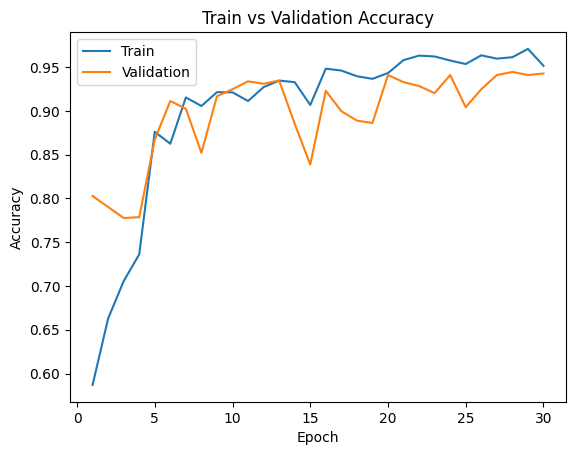

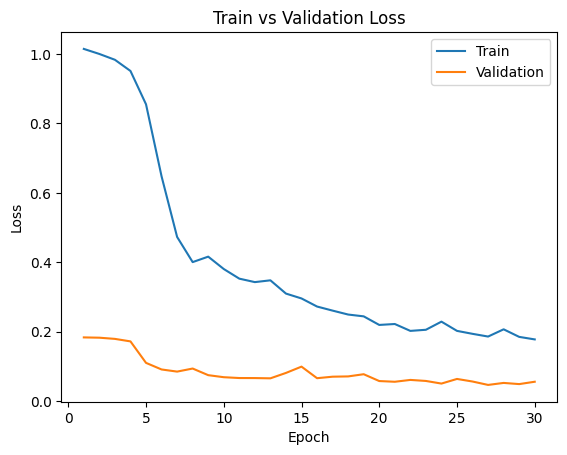

In [142]:
batch_size = 64
num_epoch = 30
lr = 1e-4
input_size = len(text_field.vocab.itos)
model = RNN(input_size, hidden_size=50)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"
plot_training_curve(model_path)


### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [143]:
"""
For this assignment, I will be tuning the number of hidden units, RNN output value tokens, num_epoch, and learning rate
"""

# 1 change rnn output value tokens, one that uses a max pooling layer
# lower amount of epoch as it didn't make a significant difference
batch_size = 64
num_epoch = 20
lr = 1e-4
input_size = len(text_field.vocab.itos)
model = RNN_max(input_size, hidden_size=50)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.4800198971978113, Train loss: 1.0448578195646405 |Validation acc: 0.8654708520179372, Validation loss: 0.17983444035053253
Epoch 2: Train acc: 0.5984082241750953, Train loss: 1.0205432707443833 |Validation acc: 0.862780269058296, Validation loss: 0.1849192464724183
Epoch 3: Train acc: 0.8907312220195656, Train loss: 1.0025662537664175 |Validation acc: 0.905829596412556, Validation loss: 0.18696328345686197
Epoch 4: Train acc: 0.8472890067982093, Train loss: 0.9824422355741262 |Validation acc: 0.8493273542600897, Validation loss: 0.18710357509553432
Epoch 5: Train acc: 0.8673520145912784, Train loss: 0.9616471491754055 |Validation acc: 0.8672645739910314, Validation loss: 0.18436789605766535
Epoch 6: Train acc: 0.9038302105786769, Train loss: 0.9339453699067235 |Validation acc: 0.9139013452914798, Validation loss: 0.17990965116769075
Epoch 7: Train acc: 0.9479356657270768, Train loss: 0.8923299536108971 |Validation acc: 0.9479820627802691, Validation loss: 0.170782

In [147]:
"""
from above, we can see that the best accuracy is 96%. Let's now try to change the output token layer again to that of the maxpooling + mean
"""
batch_size = 64
num_epoch = 20
lr = 1e-4
input_size = len(text_field.vocab.itos)
model = RNN_max_mean(input_size, hidden_size=50)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.6517990383021058, Train loss: 1.0309517132118344 |Validation acc: 0.4367713004484305, Validation loss: 0.1952849579975009
Epoch 2: Train acc: 0.5984082241750953, Train loss: 1.0179712139070034 |Validation acc: 0.2914798206278027, Validation loss: 0.1958184214308858
Epoch 3: Train acc: 0.6060354833360968, Train loss: 1.0053057642653584 |Validation acc: 0.30493273542600896, Validation loss: 0.19527489226311445
Epoch 4: Train acc: 0.6486486486486487, Train loss: 0.9880824442952871 |Validation acc: 0.40896860986547084, Validation loss: 0.19398585986346006
Epoch 5: Train acc: 0.8244072293152048, Train loss: 0.9669720148667693 |Validation acc: 0.7354260089686099, Validation loss: 0.19022422283887863
Epoch 6: Train acc: 0.9224009285358978, Train loss: 0.9320580344647169 |Validation acc: 0.9004484304932735, Validation loss: 0.18393931072205305
Epoch 7: Train acc: 0.8973636212900017, Train loss: 0.8652003668248653 |Validation acc: 0.8251121076233184, Validation loss: 0.178

In [148]:
"""
Close to 96%. Let's see what will change if we increase the learning rate
"""
batch_size = 64
num_epoch = 20
lr = 1e-3
input_size = len(text_field.vocab.itos)
model = RNN_max_mean(input_size, hidden_size=50)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.9427955562924888, Train loss: 0.976132863201201 |Validation acc: 0.9668161434977578, Validation loss: 0.1608650702983141
Epoch 2: Train acc: 0.9495937655446858, Train loss: 0.6173789950553328 |Validation acc: 0.9641255605381166, Validation loss: 0.0849455171264708
Epoch 3: Train acc: 0.9620295141767534, Train loss: 0.29999165213666856 |Validation acc: 0.9542600896860987, Validation loss: 0.05404380883555859
Epoch 4: Train acc: 0.9646824738849279, Train loss: 0.22249221138190478 |Validation acc: 0.957847533632287, Validation loss: 0.0432649131398648
Epoch 5: Train acc: 0.9688277234289504, Train loss: 0.18222267981036566 |Validation acc: 0.9614349775784753, Validation loss: 0.0362344280583784
Epoch 6: Train acc: 0.9716464931188857, Train loss: 0.1690166107728146 |Validation acc: 0.9623318385650225, Validation loss: 0.03672108275350183
Epoch 7: Train acc: 0.9738020228817775, Train loss: 0.15128753551107366 |Validation acc: 0.9641255605381166, Validation loss: 0.03152

In [149]:
"""
97%. That's good. Let's increase the hidden unit size to 200 * 2 = 400
"""
batch_size = 64
num_epoch = 20
lr = 1e-3
input_size = len(text_field.vocab.itos)
model = RNN_max_mean(input_size, hidden_size=200)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.9439562261648151, Train loss: 0.866447587730363 |Validation acc: 0.9650224215246637, Validation loss: 0.08668756252154708
Epoch 2: Train acc: 0.9607030343226662, Train loss: 0.3179293039429467 |Validation acc: 0.9641255605381166, Validation loss: 0.04332441627047956
Epoch 3: Train acc: 0.9686619134471895, Train loss: 0.19967468675167765 |Validation acc: 0.9632286995515695, Validation loss: 0.03815655061043799
Epoch 4: Train acc: 0.9688277234289504, Train loss: 0.1878519561869325 |Validation acc: 0.9668161434977578, Validation loss: 0.0323665167670697
Epoch 5: Train acc: 0.9658431437572542, Train loss: 0.15413100812293123 |Validation acc: 0.9587443946188341, Validation loss: 0.04349561658455059
Epoch 6: Train acc: 0.9820925219698226, Train loss: 0.14536279303138144 |Validation acc: 0.9739910313901345, Validation loss: 0.02339076268253848
Epoch 7: Train acc: 0.9767866025534737, Train loss: 0.12653115641296608 |Validation acc: 0.9757847533632287, Validation loss: 0.0

In [151]:
"""
98%. Let's increase the learning rate again to see if it changes anything
"""
batch_size = 64
num_epoch = 20
lr = 2e-3
input_size = len(text_field.vocab.itos)
model = RNN_max_mean(input_size, hidden_size=200)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.5232963024374068, Train loss: 0.8523351661860943 |Validation acc: 0.13632286995515694, Validation loss: 0.273442261852324
Epoch 2: Train acc: 0.9535732051069474, Train loss: 0.5088364820694551 |Validation acc: 0.95695067264574, Validation loss: 0.04275766882346943
Epoch 3: Train acc: 0.9645166639031669, Train loss: 0.19889541156589985 |Validation acc: 0.9542600896860987, Validation loss: 0.04187947098398581
Epoch 4: Train acc: 0.9701542032830376, Train loss: 0.17138990623061545 |Validation acc: 0.9623318385650225, Validation loss: 0.03869117220165208
Epoch 5: Train acc: 0.9754601226993865, Train loss: 0.14178155428089667 |Validation acc: 0.9623318385650225, Validation loss: 0.03266896348213777
Epoch 6: Train acc: 0.9845796716962361, Train loss: 0.12319172903517028 |Validation acc: 0.9748878923766816, Validation loss: 0.026214053388684988
Epoch 7: Train acc: 0.9570552147239264, Train loss: 0.12528028622909915 |Validation acc: 0.9695067264573991, Validation loss: 0.

In [152]:
"""
98%, but quickly became overfit. I think let's increase the hidden size again to 400 * 2 = 800 to see if it changes anything
"""
batch_size = 64
num_epoch = 20
lr = 1e-3
input_size = len(text_field.vocab.itos)
model = RNN_max_mean(input_size, hidden_size=400)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.949262145581164, Train loss: 0.7353121382184327 |Validation acc: 0.9605381165919282, Validation loss: 0.09706085454672575
Epoch 2: Train acc: 0.9572210247056873, Train loss: 0.2980744623055216 |Validation acc: 0.967713004484305, Validation loss: 0.033334149280563
Epoch 3: Train acc: 0.9670038136295805, Train loss: 0.18737467085884418 |Validation acc: 0.9668161434977578, Validation loss: 0.027989601832814515
Epoch 4: Train acc: 0.9724755430276902, Train loss: 0.16586785577237606 |Validation acc: 0.9650224215246637, Validation loss: 0.029002820258028805
Epoch 5: Train acc: 0.9789421323163654, Train loss: 0.13275261468515964 |Validation acc: 0.9713004484304932, Validation loss: 0.026639192481525242
Epoch 6: Train acc: 0.982921571878627, Train loss: 0.12784927918983158 |Validation acc: 0.9713004484304932, Validation loss: 0.022919609386008233
Epoch 7: Train acc: 0.9442878461283369, Train loss: 0.3309761366908788 |Validation acc: 0.9739910313901345, Validation loss: 0.

In [159]:
"""
Ok not too much better with more hidden size. Let's train the best model one last time
"""
batch_size = 64
num_epoch = 20
lr = 1e-3
input_size = len(text_field.vocab.itos)
model = RNN_max_mean(input_size, hidden_size=200)
train_rnn(model, train, valid, batch_size, num_epoch, lr)
model_path = f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{num_epoch-1}"

Epoch 1: Train acc: 0.9439562261648151, Train loss: 0.866447587730363 |Validation acc: 0.9650224215246637, Validation loss: 0.08668756252154708
Epoch 2: Train acc: 0.9607030343226662, Train loss: 0.3179293039429467 |Validation acc: 0.9641255605381166, Validation loss: 0.04332441627047956
Epoch 3: Train acc: 0.9686619134471895, Train loss: 0.19967468675167765 |Validation acc: 0.9632286995515695, Validation loss: 0.03815655061043799
Epoch 4: Train acc: 0.9688277234289504, Train loss: 0.1878519561869325 |Validation acc: 0.9668161434977578, Validation loss: 0.0323665167670697
Epoch 5: Train acc: 0.9658431437572542, Train loss: 0.15413100812293123 |Validation acc: 0.9587443946188341, Validation loss: 0.04349561658455059
Epoch 6: Train acc: 0.9820925219698226, Train loss: 0.14536279303138144 |Validation acc: 0.9739910313901345, Validation loss: 0.02339076268253848
Epoch 7: Train acc: 0.9767866025534737, Train loss: 0.12653115641296608 |Validation acc: 0.9757847533632287, Validation loss: 0.0

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [163]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

valid_spam_data_loader = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
valid_nospam_data_loader = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
best_model = RNN_max_mean(input_size, 200)
best_model_path = "./models/"+ f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{10}"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

# false positive rate
fp_rate = 1 - get_accuracy(best_model, valid_spam_data_loader)
# false negative rate
fn_rate = 1 - get_accuracy(best_model, valid_nospam_data_loader)

print(f"False positive: {100 * fp_rate:.02f}%")
print(f"False negative: {100* fn_rate:.02f}%")

False positive: 4.67%
False negative: 4.66%


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

**Answer**

False positive for spam detection means a non-spam message labeled as spam. The impact would be that legitimate messages gets labelled as spam, and we miss messages from friends and family.

False negative for spam detection means a spam message labeled as non-spam. The impact would be that we receive these mislabelled spam messages

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [162]:
best_model = RNN_max_mean(input_size, 200)
best_model_path = "./models/"+ f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{10}"
state = torch.load(best_model_path)
best_model.load_state_dict(state)
test_data_loader = torchtext.data.BucketIterator(test,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
test_accuracy = get_accuracy(model, test_data_loader)
print(f"test accuracy: {100 * test_accuracy:.02f}%")

test accuracy: 98.03%


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [164]:
# Create a Dataset of only spam test examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_spam_data_loader = torchtext.data.BucketIterator(test_spam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
test_nospam_data_loader = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)
best_model = RNN_max_mean(input_size, 200)
best_model_path = "./models/"+ f"model_{model.name}_bs{batch_size}_lr{lr}_epoch{10}"
state = torch.load(best_model_path)
best_model.load_state_dict(state)

# false positive rate
fp_rate = 1 - get_accuracy(best_model, valid_spam_data_loader)
# false negative rate
fn_rate = 1 - get_accuracy(best_model, valid_nospam_data_loader)

print(f"False positive: {100 * fp_rate:.02f}%")
print(f"False negative: {100* fn_rate:.02f}%")

False positive: 4.67%
False negative: 4.56%


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [171]:
msg = "machine learning is sooo cool!"
print(text_field.vocab.stoi)
msg_list = []
for c in msg:
    msg_list.append(text_field.vocab.stoi[c])
print(msg_list) # representation of the msg

tensor_msg = torch.LongTensor([msg_list])
pred = best_model(tensor_msg)
prob_of_spam = np.exp(float(pred[0][1])) / (np.exp(float(pred[0][0])) + np.exp(float(pred[0][1])))
print(f"Spam probability: {100*prob_of_spam:.02f}%")

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7deb378bda80>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, 'm': 16, '.': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, '8': 27, 'T': 28, 'k': 29, 'E': 30, '5': 31, 'v': 32, 'C': 33, 'S': 34, 'I': 35, 'O': 36, '4': 37, 'N': 38, '7': 39, 'x': 40, '6': 41, '3': 42, 'A': 43, '!': 44, 'R': 45, ',': 46, '9': 47, 'P': 48, 'W': 49, 'M': 50, 'U': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'F': 57, '/': 58, "'": 59, '?': 60, 'Y': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'V': 67, 'z': 68, '*': 69, 'j': 70, 'K': 71, 'J': 72, ')': 73, ';': 74, '+': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '#': 80, '>': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '\x92': 88, '‘': 89, '<': 90, '_': 91, '%': 92, '|': 93, '\x93': 94, '…': 95, '’': 96, '[': 97, ']': 98,

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

**Answer**

It is not an easy task. Even though our model achieve 98% accuracy, the false positive and false negative rates are still pretty high at above 5%. Ideally the spam algorithm will achieve high accuracy and have very low false negative rates in order to filter out huge amounts of spam text that one can be subjected to.

Proposed baseline model:
- naive bayes classification
- calculate the probability of each word appearing in spam and non-spam respectively
- the model takes in an email, and finds the probability of belonging in either categories using the word probabilities.
- if the email's spam probability is sufficiently high, it will be marked as spam.